# Setup

In [1]:
import figure_utilities
import constants
from stats_utilities import test_balance, run_event_study, run_did_in_R, run_sensitivity_analysis_in_R
import matplotlib.pyplot as plt
from panel_utilities import get_value_variable_names, prepare_df_for_DiD
plt.rcParams['savefig.dpi'] = 300
import os
import statsmodels.api as sm
from stats_utilities import run_event_study
from differences import ATTgt
import pandas as pd
import numpy as np
from os.path import join

In [2]:
# Store paths.
INPUT_DATA_PANEL = "../data/03_cleaned/crime_analysis_monthly.csv"
INPUT_DATA_EVICTIONS = "../data/02_intermediate/evictions.csv"
OUTPUT_TABLES = "../output/final_paper/tables"
OUTPUT_FIGURES = "../output/final_paper/figures"
OUTPUT_STATISTICS = "../output/final_paper/main_results_numbers_to_cite.tex"

## Crime Levels Around Filing Date and Latest Docket Date

In [3]:
# Get share of properties for which geocoded coordinates lie within the associated tax parcel 
df = pd.read_csv(INPUT_DATA_EVICTIONS)
share_correct_tax_parcel = df['Accuracy Type'].value_counts(normalize=True).loc['rooftop']
print(f"{share_correct_tax_parcel} is the share of properties for which the geocoded coordinates lie within the associated tax parcel")
# See https://www.geocod.io/guides/accuracy-types-scores/ for more information 

0.9314513596684042 is the share of properties for which the geocoded coordinates lie within the associated tax parcel


/var/folders/d2/xc40wfzn765fbyjgk7fz021r0000gn/T/ipykernel_14120/79098691.py:2: DtypeWarning: Columns (10,25,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_DATA_EVICTIONS)


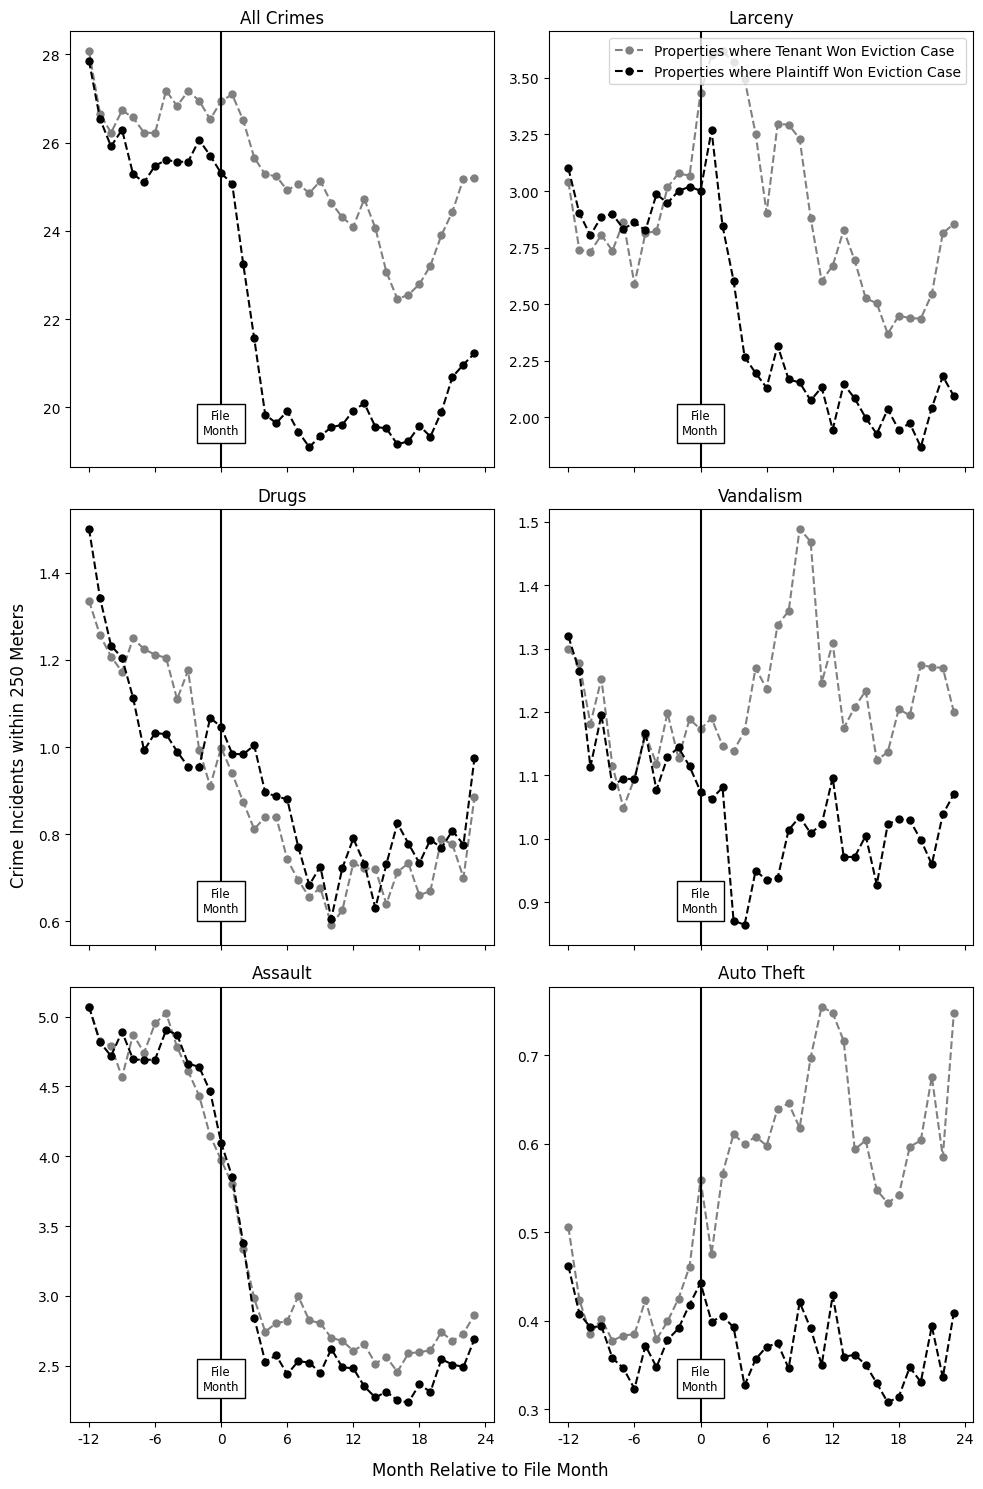

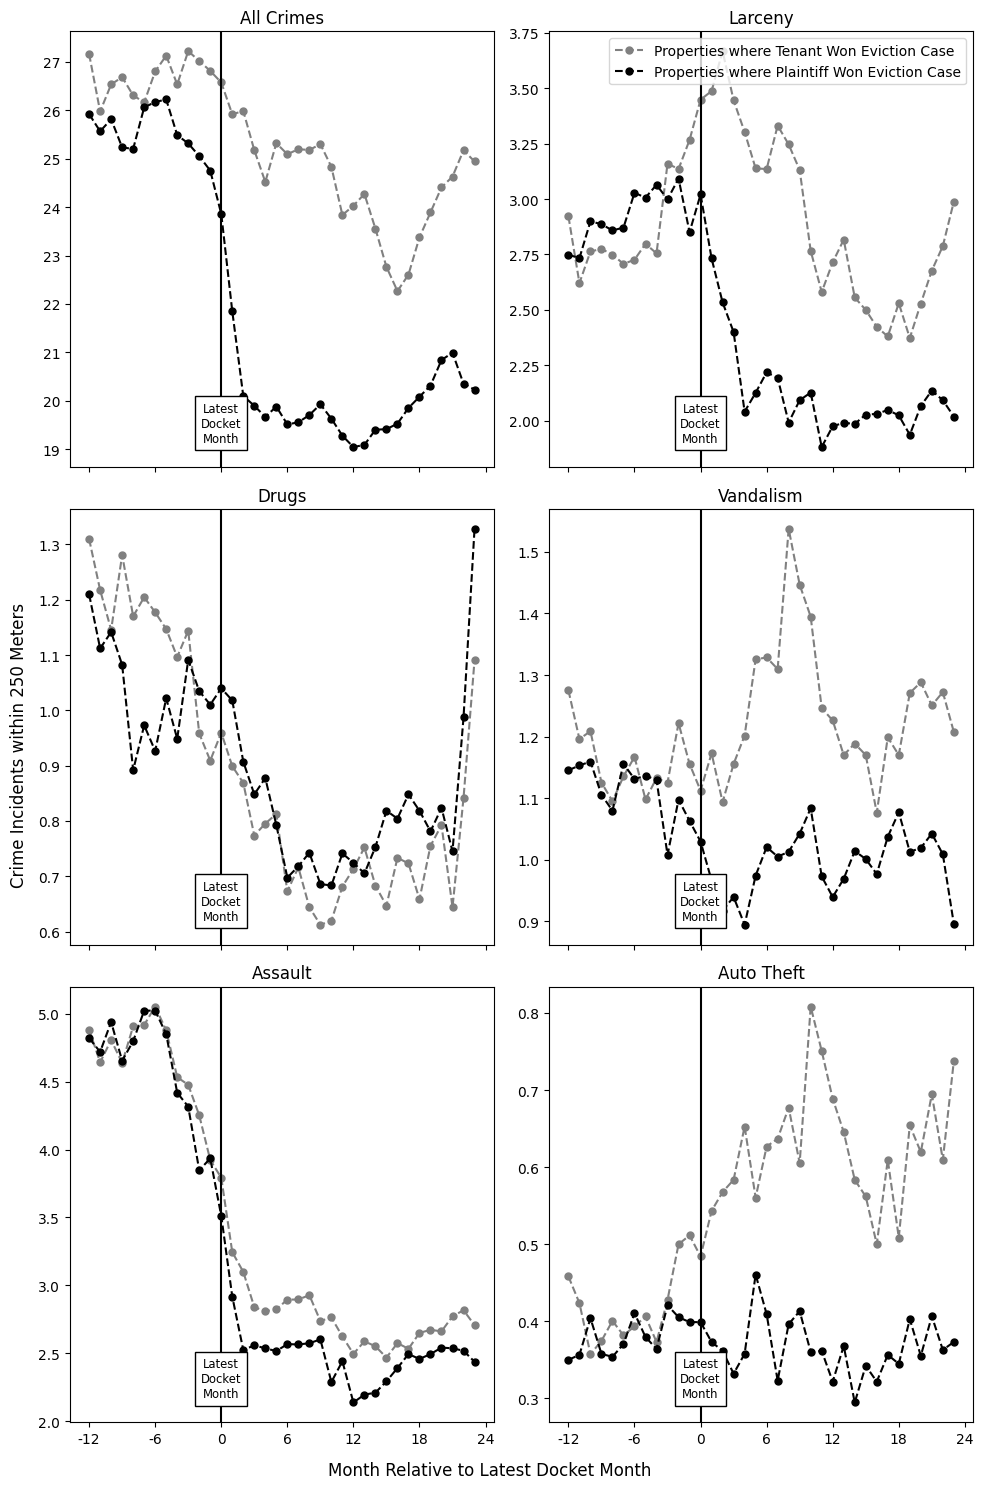

In [4]:
for treatment_date_variable in ['file_month', 'latest_docket_month']:
    fig, axes = plt.subplots(3, 2, sharex=True, figsize=(10, 15), layout='constrained')
    titles = ["All Crimes", "Larceny", "Drugs", "Vandalism", "Assault", "Auto Theft"]
    for group, (ax, title) in enumerate(zip(axes.flat, titles)):
        df = pd.read_csv(INPUT_DATA_PANEL)
        result = run_event_study(df,
                                    treatment_date_variable,
                                    f'group_{group}_crimes_{constants.Analysis.MAIN_RESULTS_RADIUS}m')
        # Normalize omitted period to zero
        omitted_period = pd.Series([0, 0], index=['month_-1', 'month_-1_X_treatment_indicator'])
        result.params = pd.concat([result.params, omitted_period], axis=0)
        month = []
        treatment = []
        control = []
        for i in range(constants.Analysis.MINIMUM_PRE_PERIOD, constants.Analysis.MAXIMUM_POST_PERIOD):
            month.append(i)
            control.append(result.params[f'month_{i}'] + result.params['const'])
            treatment.append((result.params['judgment_for_plaintiff'] +
                               result.params[f'month_{i}_X_treatment_indicator'] +
                               result.params[f'month_{i}']  +
                              result.params['const']))
    
        l2, = ax.plot(month,
            control,
            color='grey',
            linestyle='--',
            marker='o',
            markersize=5,
            label="Properties where Tenant Won Eviction Case")
        l1, = ax.plot(month,
                treatment,
                color='black',
                linestyle='--',
                marker='o',
                markersize=5,
                label="Properties where Plaintiff Won Eviction Case")
        if title == "Larceny":
            ax.legend(loc="upper right")
    
        label = "File Month".replace(" ", "\n") if treatment_date_variable == 'file_month' else "Latest Docket Month".replace(" ", "\n")
        figure_utilities.plot_labeled_vline(ax, x=0, text=f"{label}", color='black', linestyle='-',
                               text_y_location_normalized=0.1)
        
        ax.set_title(title)
        ax.set_xticks(range(constants.Analysis.MINIMUM_PRE_PERIOD, constants.Analysis.MAXIMUM_POST_PERIOD + 1, 6),
                      range(constants.Analysis.MINIMUM_PRE_PERIOD, constants.Analysis.MAXIMUM_POST_PERIOD + 1, 6))
    supxlabel = "Month Relative to File Month" if treatment_date_variable == 'file_month' else "Month Relative to Latest Docket Month"
    fig.supxlabel(supxlabel)
    fig.supylabel(f"Crime Incidents within {constants.Analysis.MAIN_RESULTS_RADIUS} Meters")
    plt.tight_layout()
    plt.show()
    figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, f"crime_trends_around_{treatment_date_variable}_all_groups.png"))

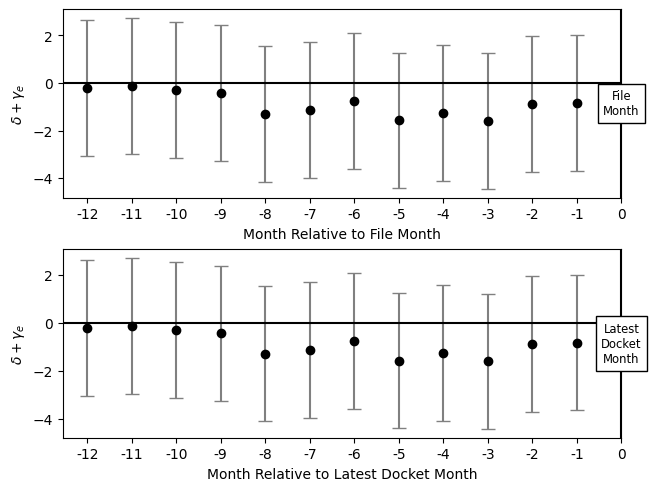

In [5]:
df = pd.read_csv(INPUT_DATA_PANEL)
result_file_month = run_event_study(df,
                                       'file_month',
                                       f'group_0_crimes_{constants.Analysis.MAIN_RESULTS_RADIUS}m')
result_latest_docket_month = run_event_study(df,
                                       'latest_docket_month',
                                       f'group_0_crimes_{constants.Analysis.MAIN_RESULTS_RADIUS}m')

file_month_point_estimates = []
file_month_p_values = []
latest_docket_month_point_estimates = []
latest_docket_month_p_values = []
file_month_standard_errors = []
latest_docket_month_standard_errors = []
for result, point_estimates, p_values, standard_errors in zip([result_file_month, result_latest_docket_month],
                                                              [file_month_point_estimates, latest_docket_month_point_estimates],
                                                              [file_month_p_values, latest_docket_month_p_values],
                                                              [file_month_standard_errors, latest_docket_month_standard_errors]):
    for i in range(constants.Analysis.MINIMUM_PRE_PERIOD, -1):
        hypothesis = f"month_{i}_X_treatment_indicator + judgment_for_plaintiff = 0"
        t_test = result.t_test(hypothesis)
        point_estimates.append(result.params[f'month_{i}_X_treatment_indicator'] + result.params['judgment_for_plaintiff'])
        p_values.append(t_test.pvalue)
        standard_errors.append(t_test.sd)
    # Hypothesis test for omitted category
    hypothesis = f"judgment_for_plaintiff = 0"
    t_test = result.t_test(hypothesis)
    point_estimates.append(result.params['judgment_for_plaintiff'])
    p_values.append(t_test.pvalue)
    standard_errors.append(t_test.sd)


fig, (ax1, ax2) = plt.subplots(2, 1, layout='constrained')
months = list(range(constants.Analysis.MINIMUM_PRE_PERIOD, 0))
ax1.errorbar(months, file_month_point_estimates, 1.96 * np.array(latest_docket_month_standard_errors).flatten(), ecolor='grey', color='black', marker='o', linestyle='', capsize=5)
ax1.set_xlabel("Month Relative to File Month")
ax1.set_xticks(range(constants.Analysis.MINIMUM_PRE_PERIOD, 1, 1),
               range(constants.Analysis.MINIMUM_PRE_PERIOD, 1, 1))
ax1.set_ylabel("$\\delta + \\gamma_e$")


ax2.errorbar(months, file_month_point_estimates, 1.96 * np.array(file_month_standard_errors).flatten(), ecolor='grey', color='black', marker='o', linestyle='', capsize=5)
ax2.set_xlabel("Month Relative to Latest Docket Month")
ax2.set_xticks(range(constants.Analysis.MINIMUM_PRE_PERIOD, 1, 1),
               range(constants.Analysis.MINIMUM_PRE_PERIOD, 1, 1))
ax2.set_ylabel("$\\delta + \\gamma_e$")

figure_utilities.plot_labeled_vline(ax1, x=0, text="File\nMonth", color='black', linestyle='-',
                       text_y_location_normalized=0.5)
figure_utilities.plot_labeled_vline(ax2, x=0, text="Latest\nDocket\nMonth", color='black', linestyle='-',
                       text_y_location_normalized=0.5)
figure_utilities.plot_labeled_hline(ax1, y=0, text="", color='black', linestyle='-', zorder=6)
figure_utilities.plot_labeled_hline(ax2, y=0, text="", color='black', linestyle='-', zorder=6)
plt.show()
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, f"levels_test.png"))

In [6]:
# Calculate percentage fall in all crimes in the treatment group
treatment_group_month_0_level = result_file_month.params.loc[['month_0', 'judgment_for_plaintiff', 'month_0_X_treatment_indicator']].sum()
treatment_group_month_3_level = result_file_month.params.loc[['month_3', 'judgment_for_plaintiff', 'month_3_X_treatment_indicator']].sum()
percent_fall_treatment_group = round(100 * ((treatment_group_month_0_level - treatment_group_month_3_level) / treatment_group_month_0_level), 2)
# Calculate percentage fall in all crimes in the control group
percent_fall_control_group = \
    round(100 *((result_latest_docket_month.params.loc['month_0'] - result_latest_docket_month.params.loc['month_3']) / result_latest_docket_month.params.loc['month_0']), 2)

In [7]:
# Calculate minimum post-treatment difference in percent terms between treatment and control group 
post_treatment_gaps_as_pct_of_control_group = []
for post_treatment_period in range(4, 22):
    post_treatment_gap = -1 *result_latest_docket_month.params.loc[['judgment_for_plaintiff', f'month_{post_treatment_period}_X_treatment_indicator']].sum()
    post_treatment_gap_as_pct_of_control_group = round((100 * (post_treatment_gap / result_latest_docket_month.params.loc[f'month_{post_treatment_period}'])), 2)
    post_treatment_gaps_as_pct_of_control_group.append(post_treatment_gap_as_pct_of_control_group)
smallest_post_treatment_percent_change = min(post_treatment_gaps_as_pct_of_control_group)

In [8]:
df = pd.read_csv(INPUT_DATA_PANEL)
treatment_date_variable = 'file_month'
analysis = f'group_0_crimes_{constants.Analysis.MAIN_RESULTS_RADIUS}m'
weekly_value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = get_value_variable_names(df, analysis)
# Re-Balance on Controls
balance_table = test_balance(df, analysis, None)
balance_table = figure_utilities.add_column_numbers(balance_table)

Optimization terminated successfully.
         Current function value: 0.682431
         Iterations 4
['total_twenty_seventeen_group_0_crimes_250m', 'month_neg_twelve_group_0_crimes_250m', 'month_neg_six_group_0_crimes_250m', 'med_hhinc2016', 'poor_share2010', 'popdensity2010', 'share_white2010', 'non_payment']


In [9]:
balance_table

\
                                      Cases Won by Defendant   
                                                         (1)   
Panel A All Crime Reports, 2017                   355.311239   
        All Crime Reports, Month -12               28.074928   
        All Crime Reports, Month -6                26.220461   
Panel B Median household income, 2016           44487.737752   
        Poverty rate, 2010                          0.306112   
        Population density, 2010                23909.964123   
        Share white, 2010                           0.310894   
Panel C Defendant has attorney                      0.048991   
        Filing for nonpayment                       0.858790   

                                      Difference in Cases Won by Plaintiff  \
                                                                Unweighted   
                                                                       (2)   
Panel A All Crime Reports, 2017                                  -3.222436   
        All Crime Reports, Month -12                             -0.219072   
        All Crime Reports, Month -6                              -0.744271   
Panel B Median household income, 2016                          3895.833676   
        Poverty rate, 2010                                       -0.033746   
        Population density, 2010                               -985.275246   
        Share white, 2010                                         0.004100   
Panel C Defendant has attorney                                   -0.045130   
        Filing for nonpayment                                    -0.078867   

                                                                                
                                           \emph{p}     Weighted      \emph{p}  
                                                (3)          (4)           (5)  
Panel A All Crime Reports, 2017        8.154009e-01   -11.008758  4.312696e-01  
        All Crime Reports, Month -12   8.406503e-01    -0.813344  4.587230e-01  
        All Crime Reports, Month -6    4.707792e-01    -0.730929  4.754653e-01  
Panel B Median household income, 2016  3.035190e-03 -1928.577989  1.622395e-01  
        Poverty rate, 2010             1.369057e-05    -0.006490  3.927873e-01  
        Population density, 2010       1.853552e-01  -760.454592  2.991305e-01  
        Share white, 2010              7.727991e-01    -0.014373  3.201342e-01  
Panel C Defendant has attorney         2.985746e-08    -0.054538  1.147862e-09  
        Filing for nonpayment          9.110653e-05    -0.025168  2.344202e-01

In [10]:
filename = join(OUTPUT_TABLES, "balance_table.tex")
latex = (balance_table
         .rename(index=constants.Variables.variable_display_names_dict)
         .style
         .format(thousands=",",
                 na_rep='',
                 formatter="{:,.2f}")
         .format_index("\\textit{{{}}}", escape="latex", axis=0, level=0)
         .format_index("\\textit{{{}}}", escape="latex", axis=1, level=0)
         .to_latex(None,
                   column_format="llccccc",
                   hrules=True,
                   multicol_align='c',
                   clines="skip-last;data")).replace("{*}", "{3cm}")
latex = latex.split("\\\\\n")
latex.insert(1, "\\cline{4-7}\n")
latex = "\\\\\n".join(latex)

with open(filename, 'w') as file:
    file.write(latex)

# Differences in Differences Estimates

In [ ]:
df = pd.read_csv(INPUT_DATA_PANEL)

unc_att_e_result_tidy, unc_att_e_result = run_did_in_R(df=df,
                                                     analysis=analysis,
                                                     treatment_date_variable=treatment_date_variable,
                                                     pre_treatment_covariates=[],
                                                     value_vars=weekly_value_vars_crime,
                                                     period_to_int_dictionary=month_to_int_dictionary)
fig, ax = plt.subplots(layout='constrained')
figure_utilities.plot_att_e(unc_att_e_result_tidy,
                            unc_att_e_result['overall.att'][0],
                            unc_att_e_result['overall.se'][0], ax=ax)
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "att_gt_unconditional_all_crimes.png"))


In [ ]:
df = pd.read_csv(INPUT_DATA_PANEL)

dr_att_e_result_tidy, dr_att_e_result = run_did_in_R(df=df,
                                                     analysis=analysis,
                                                     treatment_date_variable=treatment_date_variable,
                                                     pre_treatment_covariates=constants.Variables.pre_treatment_covariates_to_include,
                                                     value_vars=weekly_value_vars_crime,
                                                     period_to_int_dictionary=month_to_int_dictionary)
fig, ax = plt.subplots(layout='constrained')
figure_utilities.plot_att_e(dr_att_e_result_tidy,
                            dr_att_e_result['overall.att'][0],
                            dr_att_e_result['overall.se'][0], ax=ax)
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "att_gt_dr_all_crimes.png"))


In [ ]:
df = pd.read_csv(INPUT_DATA_PANEL)

dr_att_e_result_tidy, dr_att_e_result = run_did_in_R(df=df,
                                                     analysis=analysis,
                                                     treatment_date_variable='latest_docket_month',
                                                     pre_treatment_covariates=constants.Variables.pre_treatment_covariates_to_include,
                                                     value_vars=weekly_value_vars_crime,
                                                     period_to_int_dictionary=month_to_int_dictionary)
fig, ax = plt.subplots(layout='constrained')
figure_utilities.plot_att_e(dr_att_e_result_tidy,
                            dr_att_e_result['overall.att'][0],
                            dr_att_e_result['overall.se'][0], ax=ax)
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "att_gt_dr_all_crimes_latest_docket_month.png"))


In [ ]:
df = pd.read_csv(INPUT_DATA_PANEL)
# Drop cases where the defendant has an attorney
df = df.loc[df['hasAttyD'] == 0, :]
dr_att_e_result_tidy, dr_att_e_result = run_did_in_R(df=df,
                                                              analysis=analysis,
                                                              treatment_date_variable=treatment_date_variable,
                                                              pre_treatment_covariates=constants.Variables.pre_treatment_covariates_to_include,
                                                              value_vars=weekly_value_vars_crime,
                                                              period_to_int_dictionary=month_to_int_dictionary)
fig, ax = plt.subplots(layout='constrained')
figure_utilities.plot_att_e(dr_att_e_result_tidy,
                            dr_att_e_result['overall.att'][0],
                            dr_att_e_result['overall.se'][0], ax=ax)
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "att_gt_dr_all_crimes_minus_defendant_attorney.png"))


## HonestDiD

In [12]:
# Estimate pretrend slope
y = dr_att_e_result_tidy.loc[dr_att_e_result_tidy['event.time'] < 0, 'estimate']
x = dr_att_e_result_tidy.loc[dr_att_e_result_tidy['event.time'] < 0, 'event.time']
result = sm.OLS(y, sm.add_constant(x)).fit()
pretrend = result.params.round(2).loc['event.time']    

In [13]:
lower_bounds = []
upper_bounds = []
for event_time in range(0, 24):
    sensitivity_analysis_result = run_sensitivity_analysis_in_R(df=df,
                                            analysis=analysis,
                                            treatment_date_variable=treatment_date_variable,
                                            pre_treatment_covariates=constants.Variables.pre_treatment_covariates_to_include,
                                            value_vars=weekly_value_vars_crime,
                                            period_to_int_dictionary=month_to_int_dictionary,
                                            event_time=event_time,
                                            type_and_vector_string='type="smoothness", Mvec = seq(from = 0, to = 0.01, by =0.0025)')
    lower_bounds.append(sensitivity_analysis_result[0][-1])
    upper_bounds.append(sensitivity_analysis_result[1][-1])
honest_did_upper_bounds = pd.Series(upper_bounds)
honest_did_lower_bounds = pd.Series(lower_bounds)

R[write to console]: Warning in pre_process_did(yname = yname, tname = tname, idname = idname,  :
R[write to console]: 
 
R[write to console]:  Be aware that there are some small groups in your dataset.
  Check groups: 58.

R[write to console]: Warning in seq_len(length.out - 2L) * (del/n1) :
R[write to console]: 
 
R[write to console]:  Recycling array of length 1 in vector-array arithmetic is deprecated.
  Use c() or as.vector() instead.


R[write to console]: Warning in seq_len(length.out - 2L) * (del/n1) :
R[write to console]: 
 
R[write to console]:  Recycling array of length 1 in vector-array arithmetic is deprecated.
  Use c() or as.vector() instead.


R[write to console]: Warning in seq_len(length.out - 2L) * (del/n1) :
R[write to console]: 
 
R[write to console]:  Recycling array of length 1 in vector-array arithmetic is deprecated.
  Use c() or as.vector() instead.


R[write to console]: Warning in pre_process_did(yname = yname, tname = tname, idname = idname,  :
R[write to c

In [14]:
# Plot HonestDiD CIs
fig, ax = plt.subplots(layout='constrained')
figure_utilities.plot_att_e(dr_att_e_result_tidy,
                            dr_att_e_result['overall.att'][0],
                            dr_att_e_result['overall.se'][0], ax=ax)
ax.fill_between(dr_att_e_result_tidy['event.time'].loc[dr_att_e_result_tidy['event.time'] >= 1], honest_did_upper_bounds, honest_did_lower_bounds, facecolor=(0,0,0,0), edgecolor='black',linestyle='-')
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "att_gt_dr_all_crimes_honestdid.png"))

## Heterogeneous Treatment Effects

In [15]:
point_estimates = []
ci_uppers = []
ci_lowers = []
analysis = 'group_0_crimes_250m'
wald_p_values = []
for variable in ['med_hhinc2016',
                 'poor_share2010',
                 'popdensity2010', 
                 'share_white2010',]:
    # Read fresh copy of unrestricted dataset into memory.
    df = pd.read_csv(INPUT_DATA_PANEL)

    # Generate indicator variable for above median value of current characteristic
    median = df[variable].median()
    above_median_indicator_name = f'above_median_{variable}'
    df.loc[:, above_median_indicator_name] = 0
    df.loc[df[variable] > median, above_median_indicator_name] = 1
    above_median_df = df.loc[df[above_median_indicator_name] == 1, :]
    below_median_df = df.loc[df[above_median_indicator_name] == 0, :]
    
    # Cannot include pre-treatment covariates for power reasons
    pre_treatment_covariates = []

    weekly_value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = get_value_variable_names(df, analysis)

    # Run DiD on above median sample
    att_e_result_tidy, att_e_result = run_did_in_R(df=above_median_df,
                                                   analysis=analysis,
                                                   treatment_date_variable=treatment_date_variable,
                                                   pre_treatment_covariates=pre_treatment_covariates,
                                                   value_vars=weekly_value_vars_crime,
                                                   period_to_int_dictionary=month_to_int_dictionary)
    point_estimates.append(att_e_result['overall.att'][0])
    ci_lowers.append(att_e_result['overall.att'][0] - 1.96 * att_e_result['overall.se'])
    ci_uppers.append(att_e_result['overall.att'][0] + 1.96 * att_e_result['overall.se'])
    
    # Run DiD on below median sample
    att_e_result_tidy, att_e_result = run_did_in_R(df=below_median_df,
                                                   analysis=analysis,
                                                   treatment_date_variable=treatment_date_variable,
                                                   pre_treatment_covariates=pre_treatment_covariates,
                                                   value_vars=weekly_value_vars_crime,
                                                   period_to_int_dictionary=month_to_int_dictionary)
    point_estimates.append(att_e_result['overall.att'][0])
    ci_lowers.append(att_e_result['overall.att'][0] - 1.96 * att_e_result['overall.se'])
    ci_uppers.append(att_e_result['overall.att'][0] + 1.96 * att_e_result['overall.se'])

    


fig, ax = plt.subplots()
figure_utilities.plot_labeled_vline(ax, x=0, text="", color='black', linestyle='-')
for i, (ci_lower, ci_upper) in enumerate(zip(ci_lowers, ci_uppers)):
    ax.hlines(y=i, xmin=ci_lower, xmax=ci_upper, color='black')
ax.scatter(point_estimates, range(len(point_estimates)), color='black', s=7)
ax.set_yticks(ticks=range(len(point_estimates)),
              labels=["Above median household income, 2016",
                      "Below median household income, 2016",
                      "Above median share below poverty line, 2010",
                      "Below median share below poverty line, 2010",
                      "Above median population density, 2010",
                      "Below median population density, 2010",
                      "Above median share white, 2010",
                      "Below median share white, 2010"])
ax.set_ylabel("Sample Restriction")
ax.set_xlabel("Average Post-Treatment ATT")

figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "heterogenous_effects.png"))

R[write to console]: Warning in pre_process_did(yname = yname, tname = tname, idname = idname,  :
R[write to console]: 
 
R[write to console]:  Be aware that there are some small groups in your dataset.
  Check groups: 58.

R[write to console]: Warning in att_gt(yname = "group_0_crimes_250m", tname = "month", idname = "case_number_numeric",  :
R[write to console]: 
 
R[write to console]:  Not returning pre-test Wald statistic due to singular covariance matrix

R[write to console]: Warning in pre_process_did(yname = yname, tname = tname, idname = idname,  :
R[write to console]: 
 
R[write to console]:  Be aware that there are some small groups in your dataset.
  Check groups: 58.

R[write to console]: Warning in att_gt(yname = "group_0_crimes_250m", tname = "month", idname = "case_number_numeric",  :
R[write to console]: 
 
R[write to console]:  Not returning pre-test Wald statistic due to singular covariance matrix

R[write to console]: Warning in pre_process_did(yname = yname, tname =

## Alternative Radii

In [16]:
fig, axes = plt.subplots(1, 2, layout='constrained', sharey=True)
radii = [constants.Analysis.MAIN_RESULTS_RADIUS, constants.Analysis.MAIN_RESULTS_RADIUS + 50]
titles = [f"Crimes Within {constants.Analysis.MAIN_RESULTS_RADIUS}m", f"Crimes within {constants.Analysis.MAIN_RESULTS_RADIUS + 50}m"]
atts = []
att_ses = []
twenty_seventeen_totals = []
for ax, radius, title in zip(axes, radii, titles):
    df = pd.read_csv(INPUT_DATA_PANEL)
    twenty_seventeen_totals.append(df[f'total_twenty_seventeen_group_0_crimes_{radius}m'].mean())
    analysis = f"group_0_crimes_{radius}m"
    weekly_value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = get_value_variable_names(df, analysis)
    pre_treatment_covariates = [f'total_twenty_seventeen_group_0_crimes_{radius}m',
                            f'month_neg_twelve_group_0_crimes_{radius}m',
                            f'month_neg_six_group_0_crimes_{radius}m',
                            'med_hhinc2016',
                            'poor_share2010',
                            'popdensity2010',
                            'share_white2010',
                            'non_payment']
    # Run DiD for current radius
    att_e_result_tidy, att_e_result = run_did_in_R(df=df,
                                                   analysis=analysis,
                                                   treatment_date_variable=treatment_date_variable,
                                                   pre_treatment_covariates=pre_treatment_covariates,
                                                   value_vars=weekly_value_vars_crime,
                                                   period_to_int_dictionary=month_to_int_dictionary)
    # Plot event study 
    figure_utilities.plot_att_e(att_e_result_tidy,
                                att_e_result['overall.att'][0],
                                att_e_result['overall.se'][0], ax=ax)
    ax.set_title(title)

    # Keep track of overall ATTs and their SEs
    atts.append(att_e_result['overall.att'][0])
    att_ses.append(att_e_result['overall.se'][0])


figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "att_gt_dr_alternative_radii.png"))

R[write to console]: Warning in pre_process_did(yname = yname, tname = tname, idname = idname,  :
R[write to console]: 
 
R[write to console]:  Be aware that there are some small groups in your dataset.
  Check groups: 58.

R[write to console]: Warning in pre_process_did(yname = yname, tname = tname, idname = idname,  :
R[write to console]: 
 
R[write to console]:  Be aware that there are some small groups in your dataset.
  Check groups: 58.



In [17]:
for robustness_radius in constants.Analysis.ROBUSTNESS_RADII:
    df = pd.read_csv(INPUT_DATA_PANEL)
    analysis = f"group_0_crimes_{robustness_radius}m"
    twenty_seventeen_totals.append(df[f'total_twenty_seventeen_{analysis}'].mean())
    weekly_value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = get_value_variable_names(df, analysis)
    pre_treatment_covariates = [f'total_twenty_seventeen_group_0_crimes_{radius}m',
                            f'month_neg_twelve_group_0_crimes_{radius}m',
                            f'month_neg_six_group_0_crimes_{radius}m',
                            'med_hhinc2016',
                            'poor_share2010',
                            'popdensity2010',
                            'share_white2010',
                            'non_payment']

    # Run DiD for current radius
    att_e_result_tidy, att_e_result = run_did_in_R(df=df,
                                                   analysis=analysis,
                                                   treatment_date_variable=treatment_date_variable,
                                                   pre_treatment_covariates=pre_treatment_covariates,
                                                   value_vars=weekly_value_vars_crime,
                                                   period_to_int_dictionary=month_to_int_dictionary)

    # Keep track of overall ATTs and their SEs
    atts.append(att_e_result['overall.att'][0])
    att_ses.append(att_e_result['overall.se'][0])


R[write to console]: Warning in pre_process_did(yname = yname, tname = tname, idname = idname,  :
R[write to console]: 
 
R[write to console]:  Be aware that there are some small groups in your dataset.
  Check groups: 58.

R[write to console]: Warning in pre_process_did(yname = yname, tname = tname, idname = idname,  :
R[write to console]: 
 
R[write to console]:  Be aware that there are some small groups in your dataset.
  Check groups: 58.

R[write to console]: Warning in pre_process_did(yname = yname, tname = tname, idname = idname,  :
R[write to console]: 
 
R[write to console]:  Be aware that there are some small groups in your dataset.
  Check groups: 58.



In [18]:
atts

[-2.3376776806567294,
 -2.1575816967272,
 0.12922762771250962,
 0.7144862787944595,
 0.5725463752898828]

In [19]:
# Build table
atts_aggregated = pd.DataFrame()
atts_aggregated.loc[:, 'Treatment Effect (S.E.)'] = pd.Series(atts).round(2).astype(str) + " " + "(" + pd.Series(att_ses).round(2).astype(str) + ")"
atts_aggregated.loc[:, 'Total Incidents, 2017 (Mean Property)'] = pd.Series(twenty_seventeen_totals).round(2)
atts_aggregated.loc[:, 'Treatment Effect as \% of Mean'] = (100 * (pd.Series(atts) / atts_aggregated['Total Incidents, 2017 (Mean Property)'])).round(2).abs().astype(str)
atts_aggregated.loc[:, 'Total Incidents, 2017 (Mean Property)'] = atts_aggregated['Total Incidents, 2017 (Mean Property)'].astype(str)
atts_aggregated.index = ['250m away',
                         '300m away',
                         '250m and 300m away',
                         '250m and 350m away',
                         '250m and 400m away']
placebo_tests = pd.concat([pd.concat([atts_aggregated.iloc[0:2, :]], axis=0, keys=['Crimes Less Than']),
                pd.concat([atts_aggregated.iloc[2:6, :]], axis=0, keys=['Crimes Between'])], axis=0)
placebo_tests = figure_utilities.add_column_numbers(placebo_tests)

In [20]:
latex = (placebo_tests
                 .style
                 .format_index("\\textit{{{}}}", escape="latex", axis=0, level=0)
                 .to_latex(None,
                           column_format="llccc",
                           hrules=True,
                           multicol_align='c',
                           clines="skip-last;data"))
with open(os.path.join(OUTPUT_TABLES, "magnitudes_summary.tex"), 'w') as file:
    file.write(latex)
placebo_tests

Treatment Effect (S.E.)  \
                                                        (1)   
Crimes Less Than 250m away                     -2.34 (0.79)   
                 300m away                     -2.16 (0.89)   
Crimes Between   250m and 300m away             0.13 (0.27)   
                 250m and 350m away             0.71 (0.66)   
                 250m and 400m away             0.57 (0.74)   

                                    Total Incidents, 2017 (Mean Property)  \
                                                                      (2)   
Crimes Less Than 250m away                                         353.61   
                 300m away                                         485.21   
Crimes Between   250m and 300m away                                 131.6   
                 250m and 350m away                                283.96   
                 250m and 400m away                                448.61   

                                    Treatment Effect as \% of Mean  
                                                               (3)  
Crimes Less Than 250m away                                    0.66  
                 300m away                                    0.44  
Crimes Between   250m and 300m away                            0.1  
                 250m and 350m away                           0.25  
                 250m and 400m away                           0.13

## Write Statistics to File

In [27]:
with open(OUTPUT_STATISTICS, 'w') as file:
    group_0_att_250m = placebo_tests.loc[('Crimes Less Than', '250m away'), ('Treatment Effect (S.E.)', '(1)')].split(" ")[0]
    file.write(f"\n\\def\\groupzeroatt{'{' + str(group_0_att_250m) + ' }'}\n")

    group_0_att_250m_se = (placebo_tests.loc[('Crimes Less Than', '250m away'), ('Treatment Effect (S.E.)', '(1)')]
                           .split(" ")[1]
                           .replace("(", "")
                           .replace(")", ""))
                           
    file.write(f"\n\\def\\groupzeroattse{'{' + str(group_0_att_250m_se) + '}'}\n")

    group_0_att_250m_unconditional = unc_att_e_result['overall.att'][0]
    file.write(f"\n\\def\\groupzeroattunconditional{'{' + f'{group_0_att_250m_unconditional : .2f}' + '}'}\n")
    
    group_0_att_250m_unconditional_se = unc_att_e_result['overall.se'][0]
    file.write(f"\n\\def\\groupzeroattunconditionalse{'{' + f'{group_0_att_250m_unconditional_se : .2f}' + '}'}\n")


    group_0_att_250m_as_percent_of_mean = placebo_tests.loc[('Crimes Less Than', '250m away'), ('Treatment Effect as \% of Mean', '(3)')]
    file.write(f"\n\\def\\groupzeroattaspercentofmean{'{' + str(group_0_att_250m_as_percent_of_mean) + ' }'}\n")
    
    
    group_0_att_350m = placebo_tests.loc[('Crimes Less Than', '300m away'), ('Treatment Effect (S.E.)', '(1)')].split(" ")[0]
    file.write(f"\n\\def\\groupzeroattwide{'{' + str(group_0_att_350m) + ' }'}\n")
 
    group_0_att_250_300m = placebo_tests.loc[('Crimes Between', '250m and 300m away'), ('Treatment Effect (S.E.)', '(1)')].split(" ")[0]
    file.write(f"\n\\def\\groupzeroattdonut{'{' + str(group_0_att_250_300m) + ' }'}\n")
    
    group_0_att_250_400m = placebo_tests.loc[('Crimes Between', '250m and 400m away'), ('Treatment Effect (S.E.)', '(1)')].split(" ")[0]
    file.write(f"\n\\def\\groupzeroattdonutwide{'{' + str(group_0_att_250_400m) + ' }'}\n")

    file.write(f"\n\\def\\percentfallcontrolgroup{'{' + str(percent_fall_control_group) + ' }'}\n")

    file.write(f"\n\\def\\percentfalltreatmentgroup{'{' + str(percent_fall_treatment_group) + ' }'}\n")

    file.write(f"\n\\def\\smallestposttreatmentpercentchange{'{' + str(smallest_post_treatment_percent_change) + ' }'}\n")

    file.write(f"\n\\def\\numpretreatmentcovariates{'{' + str(len(constants.Variables.pre_treatment_covariates_to_include)) + ' }'}\n")
    
    
    file.write(f"\n\\def\\pretrend{'{' + str(pretrend) + '}'}\n")


